<h2 style='color:green'> Imports </h2>


In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import imageio

from glob import glob
from matplotlib import pyplot as plt
from IPython import display
from termcolor import colored
from tqdm import tqdm
from IPython.display import Image
from IPython import display

def color_print(print_str,
                 print_color='green'):
    
    '''print in given  color (default green)'''
    print(colored(print_str,print_color))



**Config**

In [1]:



class CFG:

    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    
    #loss parameter 
    LAMBDA = 100
    
    BUFFER_SIZE = 500
    
    BATCH_SIZE = 1
    

<h2 style='color:green'> Data directories </h2>


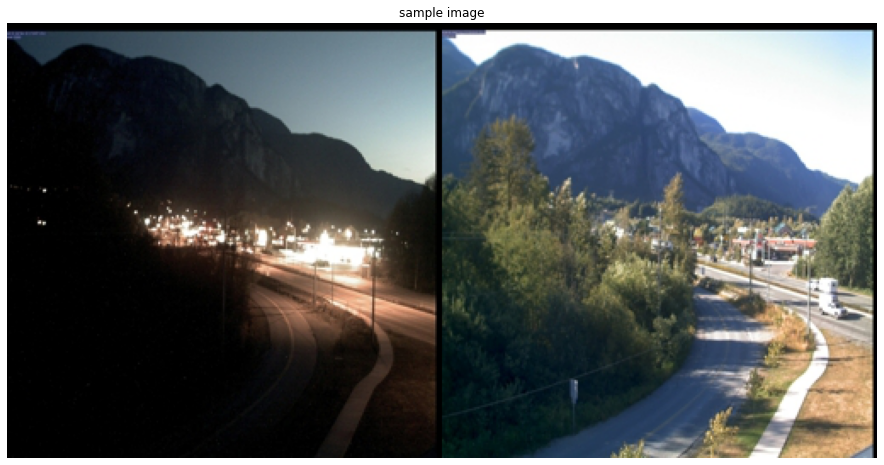

In [3]:
train_dir = '../input/night2day/night2day/train'
val_dir = '../input/night2day/night2day/val'
test_dir = '../input/night2day/night2day/test'


#plotting a sample image 

plt.figure(figsize=(16,8))

img = plt.imread(train_dir + '/' + os.listdir(train_dir)[10])
plt.imshow(img)
plt.axis('off')
plt.title('sample image')
plt.show()


**Img processing**

    loading and splitting images into Input and target 

In [5]:
def load_image(image_file):
    '''load a image file'''
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    return image

def load(image_file):
    # Read as int tensor
    image = load_image(image_file)
    
    #split image to input and target image
    w = tf.shape(image)[1]
    w = w // 2
    
    
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image,real_image

**Resizing and cropping**

In [6]:
def resize(input_image, real_image, height, width):
    '''reseize the image based on given height and width'''
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    '''perform random cropping on the input and output image'''
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]



# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    '''normalize a image to be in range -1 to 1'''
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image


def de_normalize(image):
    '''De normalize the image to be in range (0,1)'''
    
    return (image * 0.5) + 0.5
    
    

In [7]:


@tf.function()
def random_jitter(input_image, real_image):
    '''resize the image and perform a random crop simentanously on both the input and the target image'''
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image



def load_image_train(image_file):
    '''loads the image and performs required preprocessing'''
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


Number of Images in train dataset are 17823


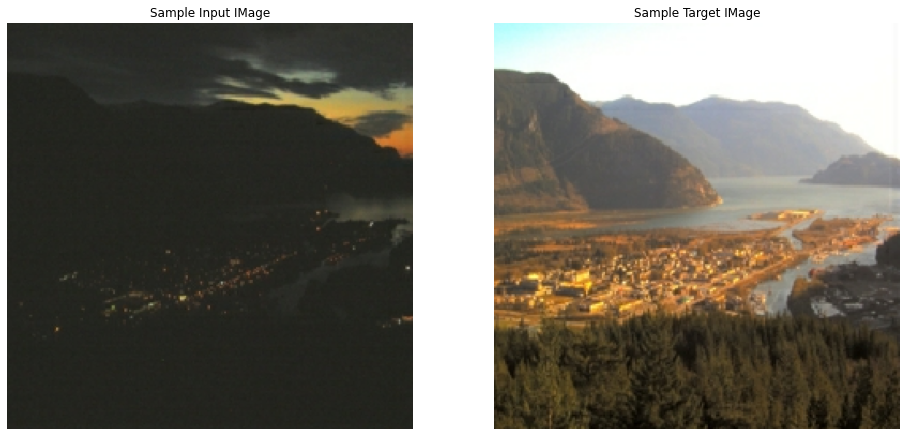

In [8]:
def create_img_dataset(directory,
                       image_extension = 'jpg'
                      ):
    '''create a tf dataset object from a directory of images'''
    img_list = glob(directory+f'/*{image_extension}')
    
    dataset = tf.data.Dataset.list_files(img_list)
    
    dataset = dataset.map(load_image_train,
                            num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(CFG.BUFFER_SIZE)
    dataset = dataset.batch(CFG.BATCH_SIZE)
    
    return dataset


train_dataset = create_img_dataset(directory = train_dir)

color_print(f'Number of Images in train dataset are {tf.data.experimental.cardinality(train_dataset).numpy()}')



#plot smaple imaes
for inp_img, target_img in train_dataset.take(1):
    fig,ax = plt.subplots(1,2,figsize=(16,8))
    
    plt.subplot(1,2,1)
    plt.imshow(inp_img[0]*0.5 + 0.5)
    plt.title('Sample Input IMage')
    plt.axis('off')
    
    
    plt.subplot(1,2,2)
    plt.imshow(target_img[0]*0.5 + 0.5)
    plt.title('Sample Target IMage')
    plt.axis('off')
    
    

    validation dataset

In [9]:

val_dataset = create_img_dataset(directory = val_dir)

color_print(f'Number of Images in train dataset are {tf.data.experimental.cardinality(val_dataset).numpy()}')

Number of Images in train dataset are 10


    Test dataset

In [10]:

test_dataset = create_img_dataset(directory = test_dir)

color_print(f'Number of Images in train dataset are {tf.data.experimental.cardinality(test_dataset).numpy()}')

Number of Images in train dataset are 2287


<h2 style='color:green'> Building Model </h2>


In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


In [12]:
def upsample(filters, size, apply_dropout=False):
    '''performs a upsampling of the input image by applying a CONV2DTranspose layer with stride of 2'''

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:    
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

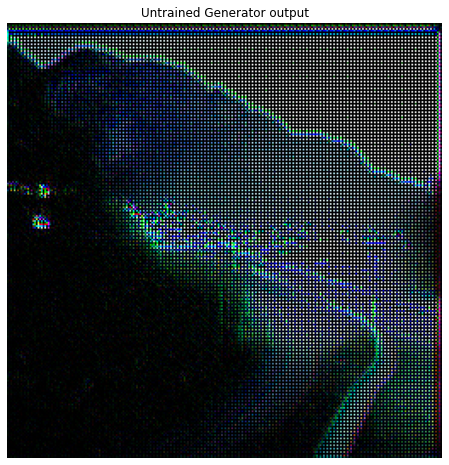

In [13]:
def Generator():
    '''a UNET generator'''
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  
    downsample(128, 4),  
    downsample(256, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    
    #list to store skip connections
    skips = []
    
    
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        
        #skip connection from the downsampling
        x = tf.keras.layers.Concatenate()([x, skip])

    out = last(x)

    return tf.keras.Model(inputs=inputs, outputs=out)


#create a instance of geenrator
generator = Generator()

#plot a sample output
gen_output = generator(img[tf.newaxis,:,:256,:], training=False)
plt.figure(figsize=(8,8))
plt.imshow(gen_output.numpy().squeeze())
plt.title('Untrained Generator output')

plt.axis('off')
plt.show()


<h3 style='color:green'> Generator loss</h3>

    The generator uses loss : Binary_crossentropy + (Lambda * Mean_absolue_loss) 


In [14]:

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    '''generator loss with the lambda param'''
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (CFG.LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


<h3 style='color:green'> Discriminator </h3>
    
    Patch GAN discriminator, which discriminates if patches in the image are real or fake

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()

<h3 style='color:green'> Discriminator loss</h3>


In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

<h2 style='color:green'> Optimizer and Training Checkpointing </h2>


In [17]:
#Generator and discriminator optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


#checkpointing model weights
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=2)


<h3 style='color:green'>function for generating and saving images</h3>


In [18]:
step_num = 0
!mkdir training_progress 

def generate_images(model, 
                    test_input, 
                    target_image,
                    save_fig = False,
                    save_dir ='./training_progress'
                   ):
    '''plot the generated image with the original imagas'''
    prediction_img = model(test_input, training=True)
    fig,ax = plt.subplots(1,3,figsize=(15, 5))

    display_list = [test_input[0], target_image[0], prediction_img[0]]
    
    step_n = str(globals()['step_num'])
    title = ['Input Image', 'Ground Truth', f'Predicted Image {step_n}']

    for i,axis in enumerate(ax):
        axis.set_title(title[i])       
        axis.imshow(de_normalize(display_list[i]))
        axis.set_axis_off()
    plt.show()
        
    if save_fig:
        globals()['step_num'] += 1
        
        step_num = globals()['step_num']
        save_name = f'{save_dir}/im_{step_num}'
        fig.savefig(save_name,bbox_inches='tight', pad_inches=0)


**Logs writer**

In [19]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


<h2 style='color:green'> Defining training step and loop</h2>


In [20]:
@tf.function
def train_step(input_image, target, step):
    '''train a single step of the pix2pix gan'''
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        #generate synthetic output
        gen_output = generator(input_image, training=True)
        
        # ------------------------discriminator on ground truth data ----------------------
        disc_real_output = discriminator([input_image, target], training=True)
        
        # ------------------------discriminator on generated data ----------------------
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        
        # ------------------------generator loss ----------------------
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        # ------------------------discriminator loss----------------------
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        
        
    # -----------------applying gradients WRT loss function -----------------------
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    # ----------------logging --------------------------------------
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [21]:
def reduce_optimizer_lr(factor):
    '''reduce optimizer_learning rate'''
    generator_optimizer.lr = generator_optimizer.lr * factor 
    discriminator_optimizer.lr = discriminator_optimizer.lr * factor 
    
    print(f'Reduce Learning Rate to {generator_optimizer.lr}')
    
    return None


            


In [22]:
def fit(train_ds,
        test_ds, 
        num_iterations
       ):
    '''Custom fit function'''
    
    #get a example for plotting every 1000th step
    example_input, example_target = next(iter(test_ds.shuffle(100).take(1)))
    start = time.time()
    
    
    for step, (input_image, target) in tqdm(train_ds.repeat().take(num_iterations).enumerate(),desc = 'Training step :'):
        

        # ------------------------training step ----------------------------------------        

        train_step(input_image=input_image, 
                   target=target,
                   step=step)
        

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            save_path = manager.save()

            display.clear_output(wait=True)

            #save generated image    
            generate_images(generator, example_input, example_target,save_fig=True)
            print('Saving generated images in directory')
            
            
        #----------------reduce lr------------------    
        if (step + 1) %10000==0: 
            #reduce learning rate 
            reduce_optimizer_lr(factor=0.75)

        #------------------------PLot original and geenrated samples ----------------------        
        if (step) % 1000 == 0:
        
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            generate_images(model = generator, 
                            test_input= example_input,
                            target_image=example_target)
            print(f"Step: {step//1000}k")
                    
    
    
    
    



<h2 style='color:green'> Training Pix2Pix GAN</h2>


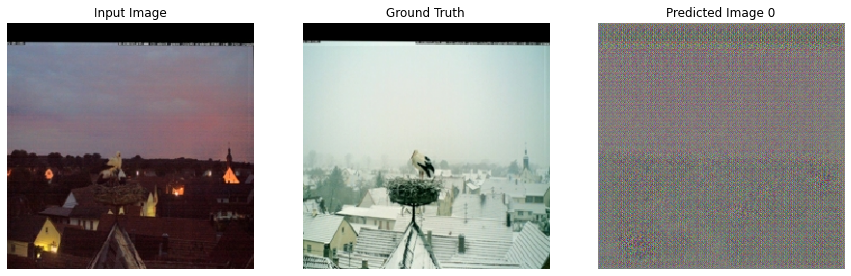

Training step ::   0%|          | 3/1000 [00:09<39:23,  2.37s/it]  

Step: 0k


Training step :: 100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


In [23]:
fit(train_ds = train_dataset, 
    test_ds = test_dataset, 
    num_iterations=1000)


<h2 style='color:green'> Visualizing training progress</h2>


    lets create a GIFF of the training progress to see the how the generated images change.

<h2 style='color:green'>  Evaluate the Generator</h2>


In [25]:
!mkdir ./evaluation_img


def evaluate_generator(model = generator,
                       eval_dataset=test_dataset,
                       num_frames = 50,
                       save_dir='./evaluation_img'):

    for step, (input_image, target) in tqdm(iterable= eval_dataset.take(num_frames).enumerate(),desc='Generating Image | % done'):
        globals()['step_num'] = step

        generate_images(model, 
                        test_input=input_image, 
                        target_image=target,
                        save_fig = True,
                        save_dir =save_dir
                       )
        
        #clear output 
        display.clear_output(wait=True)
        
        
    return None 
        
        
def create_animation(image_directory='./evaluation_img',
                     save_name='./evaluation_anim.gif') :
    '''create animation from a list of images in directory'''
    
    imag_seq = list(sorted(glob(f'{image_directory}/*png'),key = lambda x: int(x.split('_')[-1].split('.')[0])))


    # generating a GIff 
    image_list = []
    for file_name in imag_seq:
        image_list.append(imageio.imread(file_name))

    #write as a giff file
    imageio.mimwrite(save_name, 
                     image_list,
                     fps = 2)

    
    return None
    



In [26]:
#generate images on the evaluation dataset 
_= evaluate_generator()


#make a animation of generated images 
_ = create_animation()


Generating Image | % done: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


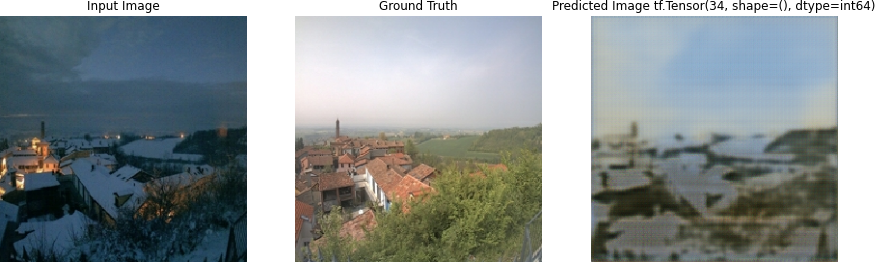

In [35]:
#display.display(Image(data = './evaluation_anim.gif',width = 1200, height = 400))
display.display(Image(data = './evaluation_img/im_35.png',width = 1200, height = 400))